### Dataset: Kaggle - Mobile Phone Defect Segmentation Dataset - About 2.500images and 6 types of damage

# 1. Import thư viện và dữ liệu

In [112]:
import gc
gc.collect()
import numpy as np
import pandas as pd

import os
from itertools import chain
import random

import matplotlib.pyplot as plt
#jupyter notebook
%matplotlib inline
from  matplotlib.image import imread

Đọc dữ liệu đã tải

In [113]:
f = "D:\\DATASET\\MobilePhoneScreenDamage\\archive"
print(os.listdir(f))
damage_classes = os.listdir(f)

['good', 'ground_truth_1', 'ground_truth_2', 'oil', 'scratch', 'stain']


# 2. Phân tích và xử lý dữ liệu đầu vào

Lấy ra các hư hỏng

In [114]:
damage = ['crack_or_stain' if breed == 'ground_truth_1' else 'ink' if breed == 'ground_truth_2' else breed for breed in damage_classes]
damage

['good', 'crack_or_stain', 'ink', 'oil', 'scratch', 'stain']

In [115]:
X = []
Y = []
fullPaths = ["D:\\DATASET\\MobilePhoneScreenDamage\\archive\\{}".format(damage_class) for damage_class in damage_classes]
for counter, fullPath in enumerate(fullPaths):
    for img in os.listdir(fullPath):
        X.append([fullPath + '\\' + img])
        Y.append(damage[counter])
print(X[:10])
print(Y[:10])

[['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0001.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0002.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0003.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0004.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0005.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0006.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0007.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0008.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0009.png'], ['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0010.png']]
['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good']


Tách các danh sách ra và nối thành 1 danh sách duy nhất

In [116]:
X = list(chain.from_iterable(X))
print(X[:10])
print("Number of images: ", len(X))

['D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0001.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0002.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0003.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0004.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0005.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0006.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0007.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0008.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0009.png', 'D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0010.png']
Number of images:  2420


Trộn (x, y) và sắp xếp hình ảnh - Trộn các hình ảnh và nhãn để chúng không được nhóm theo loại của chúng.

In [117]:
mixed = list(zip(X,Y)) #add tuples
print(mixed[:10])
random.shuffle(mixed)
print(mixed[:10])
X[:], Y[:] = zip(*mixed) #Giai nen -> 2 lists X va Y

[('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0001.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0002.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0003.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0004.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0005.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0006.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0007.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0008.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0009.png', 'good'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\good\\0010.png', 'good')]
[('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\scratch\\Scr_0378.jpg', 'scratch'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\ground_truth_2\\Oil_0095.png', 'ink'), ('D:\\DATASET\\MobilePhoneScreenDamage\\archive\\ground_truth_1\\Scr_0340.p

Lấy ngẫu nhiên 9 ảnh hư hỏng theo nhãn của chúng

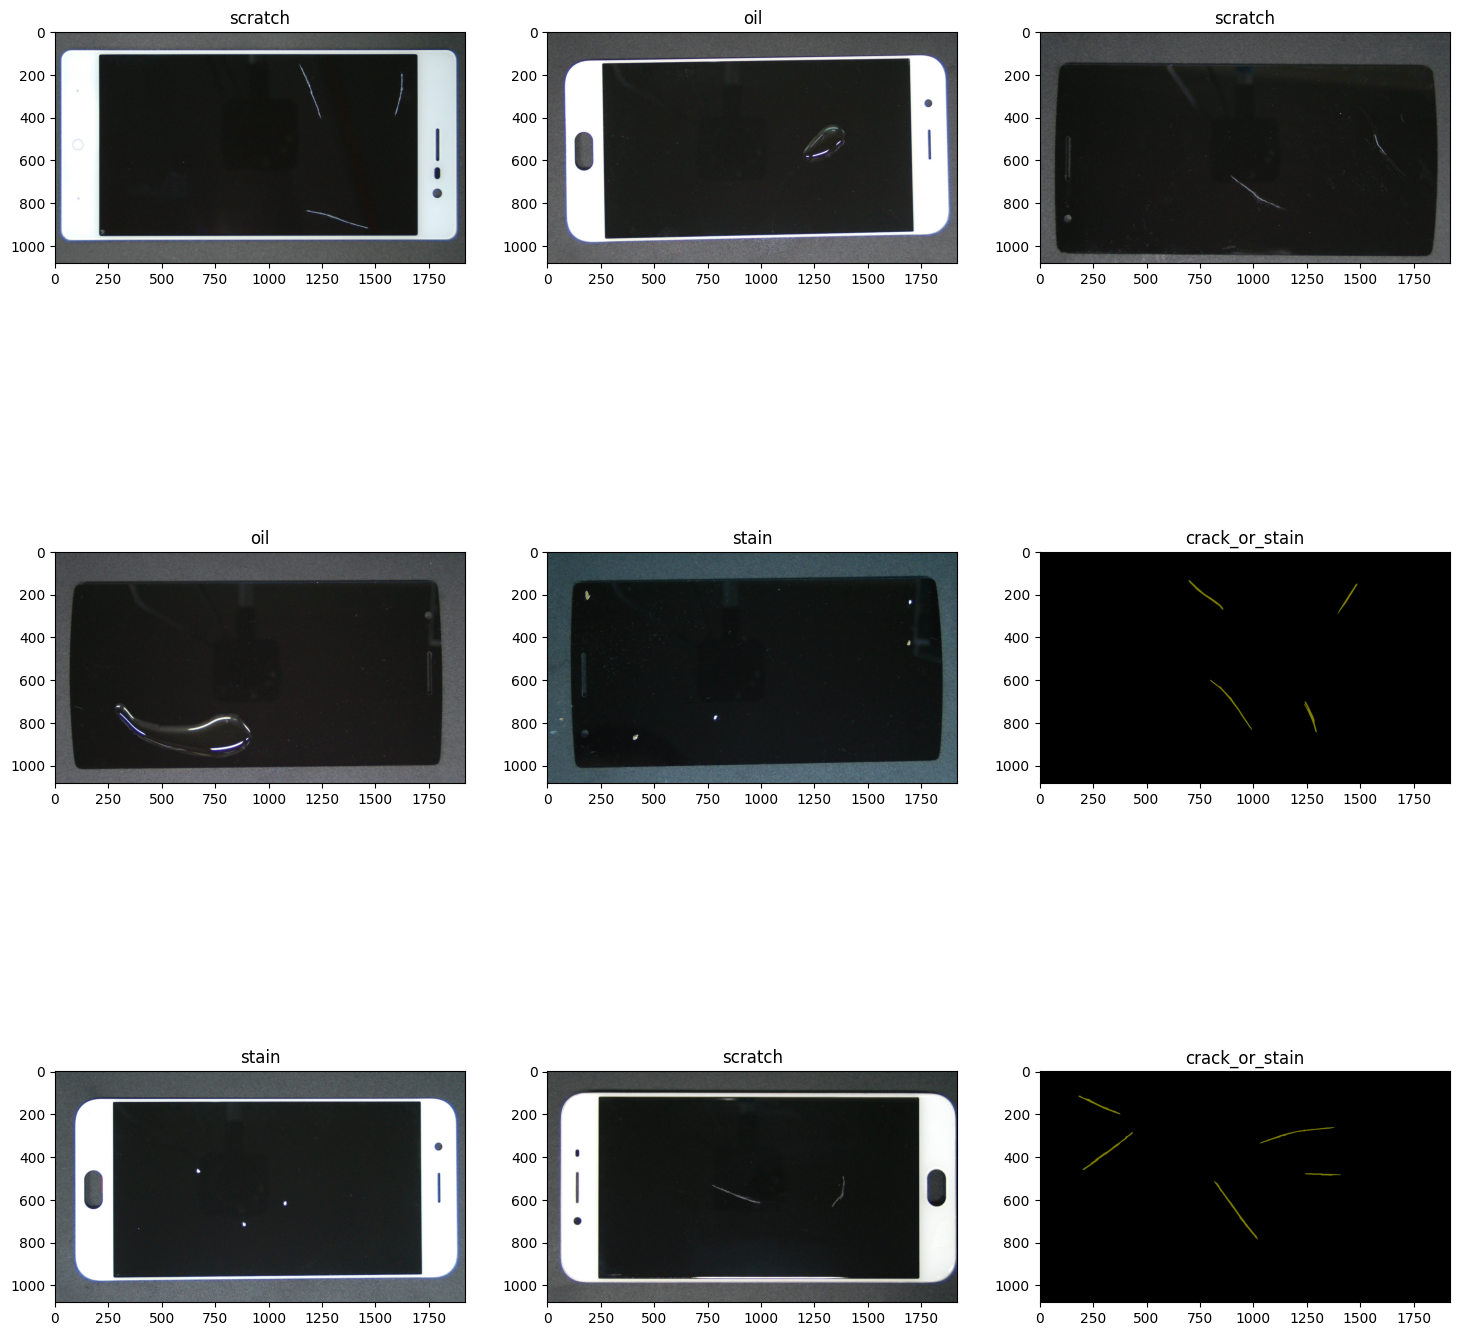

In [118]:
plt.figure(figsize=(18,18))
for counter, i in enumerate(random.sample(range(0,len(X)),9)):
    plt.subplot(3,3, counter+1)
    plt.subplots_adjust(hspace=0.5)
    fileName = X[i]
    image = imread(fileName)
    plt.imshow(image)
    plt.title(Y[i], fontsize=12)
plt.show()

# 3. Tiền xử lý dữ liệu

Mã hóa dữ liệu,
Sử dụng one-hot encoding

In [120]:
from sklearn.preprocessing import LabelEncoder
from keras.src.utils import to_categorical

le = LabelEncoder()
le.fit(Y)
y_encoding = to_categorical(le.transform(Y), len(damage))
print(y_encoding.shape) #1000images, 120labels

y_encoding = np.array(y_encoding)

(2420, 6)


Lưu danh sách tên loài vào file CSV để ứng dụng khi cần

In [121]:
damage_df = pd.DataFrame({'damage': le.classes_})
damage_df.to_csv('damage_list.csv', index=False)

print('Saved damage_list.csv')

Saved damage_list.csv


Chuẩn bị dữ liệu huấn luyện, xác thực và kiểm tra, chúng tôi tải hình ảnh lên cùng kích thước và chuyển đổi chúng thành một mảng hình ảnh,
mỗi mảng chứa các giá trị rgb của mọi pixel.


In [122]:
from sklearn.model_selection import train_test_split
from keras.src.utils.image_utils import img_to_array, load_img

img_data = np.array([img_to_array(load_img(img, target_size = (180,320))) for img in X])
print(img_data.shape)
x_train, x_test, y_train, y_test = train_test_split(img_data, y_encoding, test_size = 0.2, random_state = 2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2)

print('Training Dataset Size:', x_train.shape)
print('Validation Dataset Size:', x_val.shape)
print('Testing Dataset Size: ', x_test.shape)
print('Training Label Size:', y_train.shape)
print('Validation Label Size: ', y_val.shape)
print('Testing Label Size: ', y_test.shape)

import gc
del img_data
gc.collect()

(2420, 180, 320, 3)
Training Dataset Size: (1548, 180, 320, 3)
Validation Dataset Size: (388, 180, 320, 3)
Testing Dataset Size:  (484, 180, 320, 3)
Training Label Size: (1548, 6)
Validation Label Size:  (388, 6)
Testing Label Size:  (484, 6)


27094

In [123]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator (rescale=1/255)
validation_data_gen = ImageDataGenerator (rescale=1/255)

In [124]:
train_generator = train_data_gen.flow(x_train, y_train, shuffle = False, seed = 1)
validation_generator = validation_data_gen.flow(x_val, y_val, shuffle = False, seed = 1)

# 4. Mô hình mạng nơ ron (CNN)

In [125]:
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

model = models.Sequential()

# CNN1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(180,320,3)))
model.add(MaxPooling2D(2,2))

# CNN2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# CNN3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# Convert the output data of the CNN network from a 2-dimensional array to a 1-dimensional array
model.add(Flatten())

# Hidden layer
model.add(Dense(512, activation='relu'))

# Output layer with 6 classes
model.add(Dense(6, activation='softmax')) #6 output

# Compile the model
model.compile(optimizer=Adam(learning_rate=.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())


c:\Users\lemin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 178, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 159, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 157, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 97280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    49,807,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,904,198 (190.37 MB)

 Trainable params: 49,904,198 (190.37 MB)

 Non-trainable params: 0 (0.00 B)

None


In [126]:
# from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
# # earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2, verbose=0, mode='auto')
# earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [127]:
epochs = 30 

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/30


c:\Users\lemin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4048 - loss: 1.6170 - val_accuracy: 0.6546 - val_loss: 1.2689
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7049 - loss: 1.1495 - val_accuracy: 0.7784 - val_loss: 0.8848
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7745 - loss: 0.8051 - val_accuracy: 0.8351 - val_loss: 0.6245
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8485 - loss: 0.5594 - val_accuracy: 0.8479 - val_loss: 0.5004
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8509 - loss: 0.4646 - val_accuracy: 0.8711 - val_loss: 0.4296
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8903 - loss: 0.3865 - val_accuracy: 0.8634 - val_loss: 0.4030
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9015 - loss: 0.3356 - val_accuracy: 0.8789 - val_loss: 0.3720
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9098 - loss: 0.2942 - val_accuracy: 0.8789 - val_loss: 0.36

In [128]:
model.save('modelPhoneDamage3.h5')

Biểu đồ độ chính xác và tổn thất tôi đã lập biểu đồ về độ chính xác và tổn thất cho dữ liệu huấn luyện và xác nhận. Điều này cho chúng ta biết mô hình của chúng ta đang hoạt động như thế nào (ví dụ: underfitting, overfitting,...).

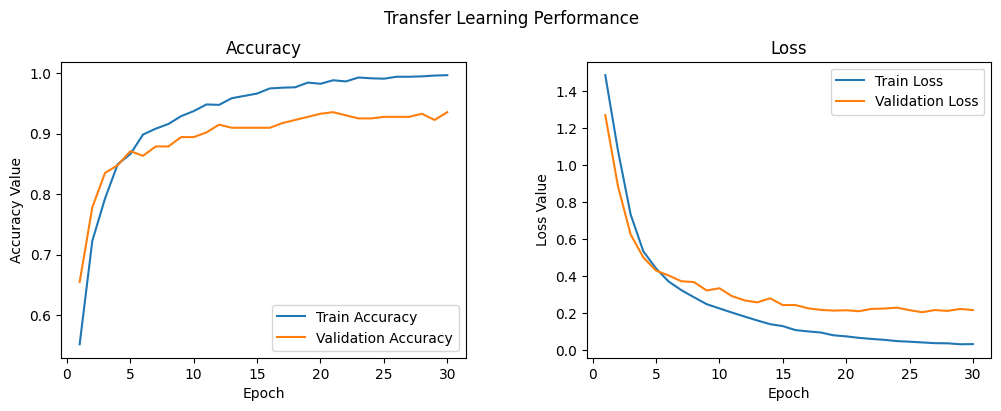

In [129]:
f, (ax1, ax2) = plt.subplots (1, 2, figsize=(12, 4))
t = f.suptitle('Transfer Learning Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks (np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks (np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch') 
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Dự đoán trên tập kiểm tra

Sau đó, áp dụng mô hình của mình cho tập dữ liệu mà nó chưa từng thấy trước đây. Điều này rất quan trọng vì muốn một mô hình có thể khái quát hóa cho các tập dữ liệu khác ngoài những gì nó được đào tạo. Một mô hình chỉ hoạt động tốt trên tập dữ liệu huấn luyện và xác thực mà không hoạt động tốt trên tập dữ liệu thử nghiệm thì không phải là một mô hình không ổn.

In [130]:
x_test1 = x_test / 255. 
test_predictions = model.predict(x_test1)

predictions = le.classes_[np.argmax(test_predictions, axis=1)]
target_labels = le.classes_[np.argmax(y_test,axis=1)]

predict_df = pd.DataFrame({'Target_Labels': target_labels, 'Predictions': predictions}) 
predict_df.head(20)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 398ms/step


,Target_Labels,Predictions
0,oil,oil
1,scratch,scratch
2,crack_or_stain,crack_or_stain
3,oil,stain
4,scratch,scratch
5,scratch,scratch
6,ink,ink
7,scratch,scratch
8,oil,stain
9,oil,oil


In [131]:
succ = (target_labels == predictions).sum()
fail = (target_labels != predictions).sum()
succ, fail

(449, 35)

Chỉ số đánh giá mô hình, tôi đo lường mức độ hoạt động của mô hình bằng cách tính toán độ chính xác của các dự đoán so với target_labels thực tế.

In [132]:
correct = (target_labels == predictions)
accuracy = correct.sum() / correct.size
print(accuracy)

0.9276859504132231


In [133]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
get_metrics (true_labels=target_labels, predicted_labels=predictions)

Accuracy: 0.9277
Precision: 0.925
Recall: 0.9277
F1 Score: 0.9246


Vẽ biểu đồ dự đoán dựa trên nhãn thực tế để hình dung rõ hơn hiệu suất dự đoán, phác thảo một loạt nhỏ tập dữ liệu thử nghiệm, cùng với nhãn thực tế, dự đoán cũng như các giá trị xác suất mà mô hình dự đoán chúng nằm trong danh mục.

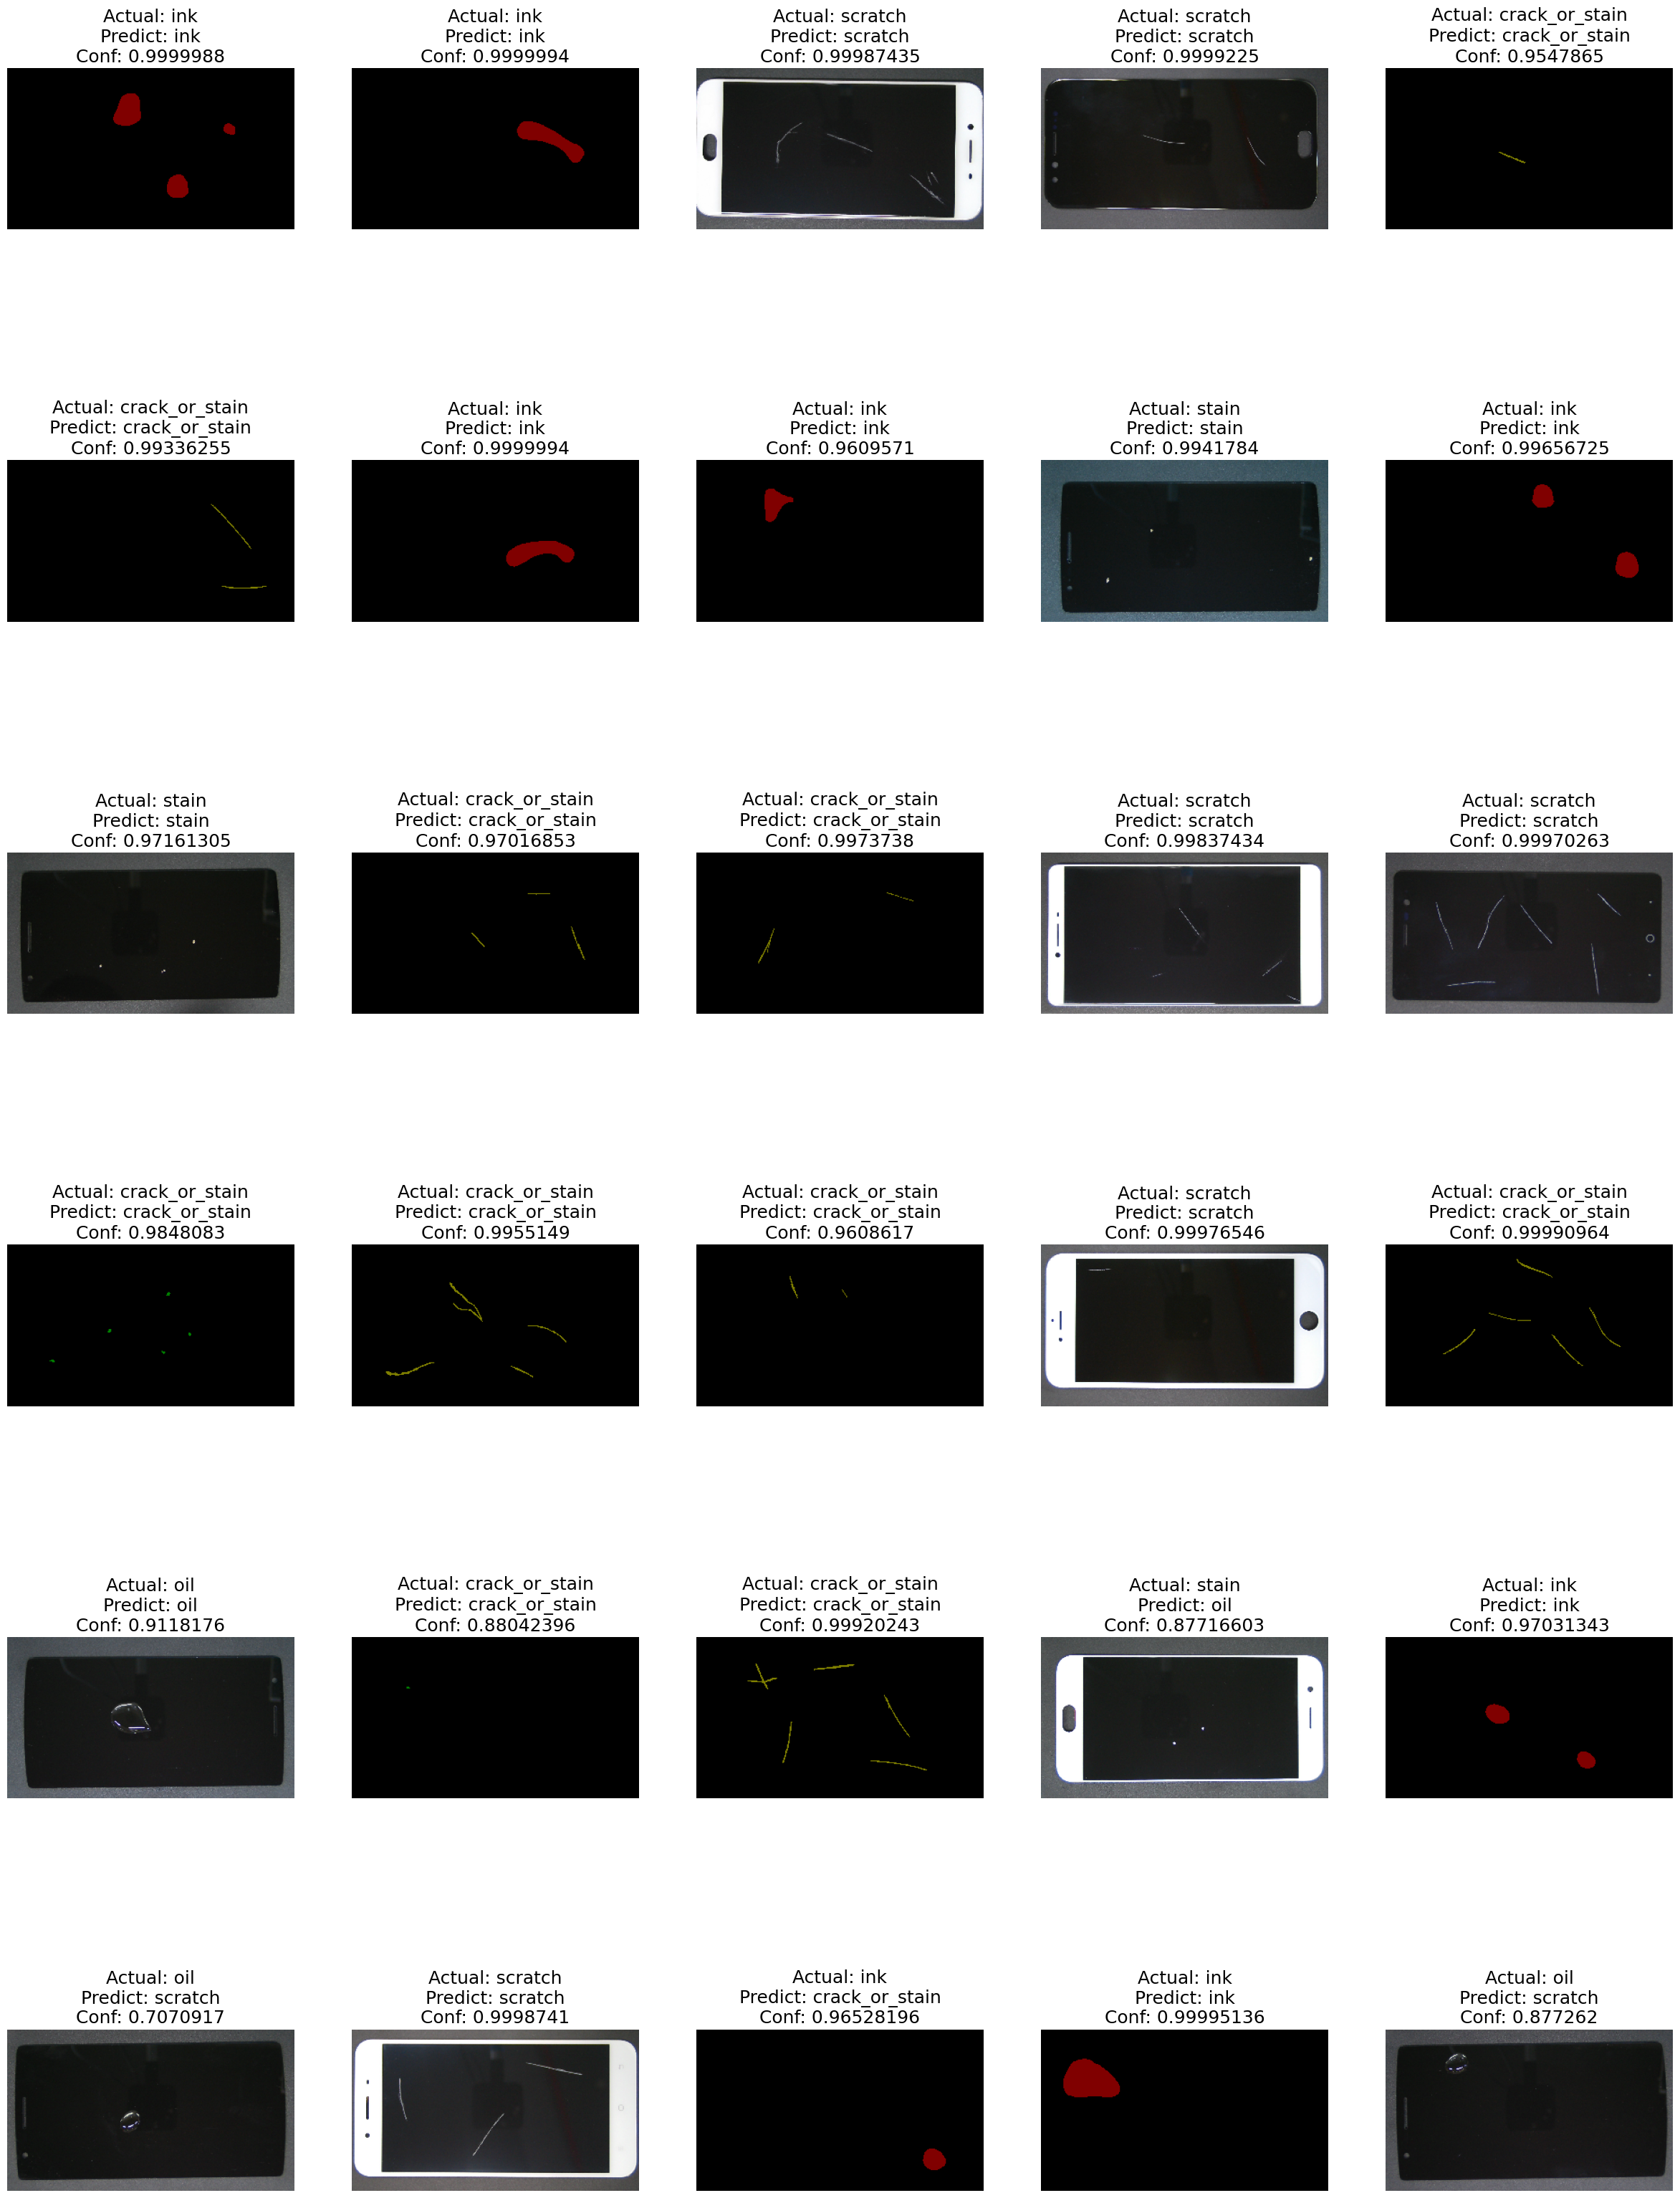

In [134]:
plt.figure(figsize=(30,40))
for counter, i in enumerate(random.sample (range(0, len(y_test)), 30)): # random 30 images 
    plt.subplot(6, 5, counter+1)
    plt.subplots_adjust(hspace=0.6)
    actual = str(target_labels[i])
    predicted = str(predictions[i])
    conf = str(max(test_predictions[i]))
    plt.imshow(x_test[i]/255.0)
    plt.axis('off')
    plt.title('Actual: ' + actual + '\nPredict: ' + predicted + '\nConf: ' + conf, fontsize=18)
plt.show()

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18070382002373429214
xla_global_id: -1
]


In [3]:
# Chỉ sử dụng GPU đầu tiên
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


In [ ]:
import io
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

model = load_model('modelPhoneDamage3.h5')
breeds_df = pd.read_csv('damage_list.csv')
breeds = breeds_df['damage'].tolist()

def preprocess_image(file_content):
    img = Image.open(io.BytesIO(file_content))

    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    img = img.resize((180, 320))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def on_upload_change(change):
    clear_output(wait=True)

    uploaded_file = next(iter(change['new']))
    img_array = preprocess_image(uploaded_file['content'])
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = float(np.max(prediction))
    
    # Hiển thị kết quả dự đoán
    print(f"Dự đoán: {breeds[predicted_class]}, Độ chính xác: {confidence:.2f}")

file_upload = widgets.FileUpload(accept='image/*', multiple=False)
file_upload.observe(on_upload_change, names='value')
display(file_upload)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Dự đoán: ink, Độ chính xác: 1.00
